## Import libraries:

In [1]:
from imports import *

## 1. Preprocessing

The data corresponds to the Monte Carlo simulation of the SBND experiment. It was obtained by simulating the creation of neutrinos in the beam and their subsequent interaction in SBND, as well as the simulation of the detector's response to the particles resulting from the interaction of the neutrinos.

In [2]:
file_path = '/data/vidales/opana_tree_combined_v0411_both.root'
file = uproot.open(file_path)
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_starttime', 'flash_ophit_amp', 'flash_ophit_area', 'flash_ophit_width', 'flash_ophit_pe', 'flash_ophit_ch']


In [3]:
# Load variables to be predicted and associated data in a single step
hit_nuvX, hit_nuvT, hit_PE, hit_ch, hit_t, flash_time, dEpromx, dEpromy, dEpromz = (optree[key].array() for key in ['nuvX','nuvT', 'flash_ophit_pe', 'flash_ophit_ch', 'flash_ophit_time','flash_time', 'dEpromx', 'dEpromy', 'dEpromz'])

**To have good time variables we need two corrections. 1- ToF from beamline origin to upstream wall of detector (110m) ~ 367 ns is the minimum that happens in the case parent hadron decays just after the beryllium target. 2- Take module 19 because we care about the relative position with respect to the max of the bunches not the absolute time in the detector window ~ 1.8us**

In [4]:
ToF_inside = optree['nuvZ'].array() / 3E10 *1E9
print("ToF_inside:",ToF_inside, "ns")
ToF_outside = 110 / 3E8 * 1E9
print(f"ToF_outside {ToF_outside:.0f} ns")
ToF_outside_set0= ak.min(hit_nuvT - ToF_inside) 
print(f"ToF_outside_set0: {ToF_outside_set0:.0f} ns")
bunch_separation = 19
print(f"bunch_separation: {bunch_separation:.0f} ns")

ToF_inside: [[3.61], [4.69], [15, 16.3], [-0.0218], ..., [11.1], [8.32], [8.73], [7.4]] ns
ToF_outside 367 ns
ToF_outside_set0: 364 ns
bunch_separation: 19 ns


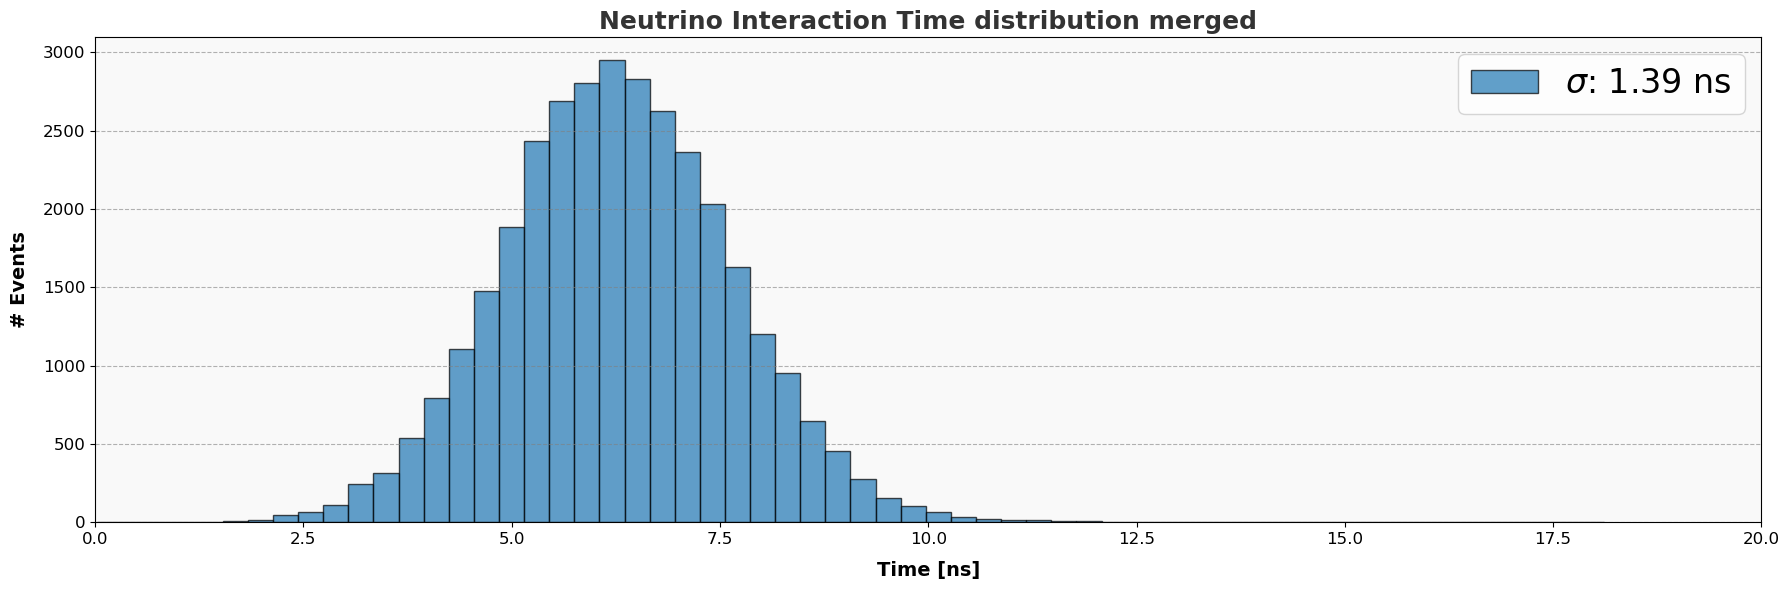

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays
# Calculate the difference and flatten it
difference = np.mod(ak.flatten(hit_nuvT - ToF_inside), 19)  # +7 to center the distribution

# Calculate the standard deviation
std_dev = np.std(difference)

# Set up the plot
plt.figure(figsize=(18, 6))
plt.hist(difference, bins=60, color='#1f77b4', edgecolor='black', alpha=0.7, label=f'$\sigma$: {std_dev:.2f} ns')

# Customize the title and labels
plt.title('Neutrino Interaction Time distribution merged', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
plt.xlim(0, 20)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()


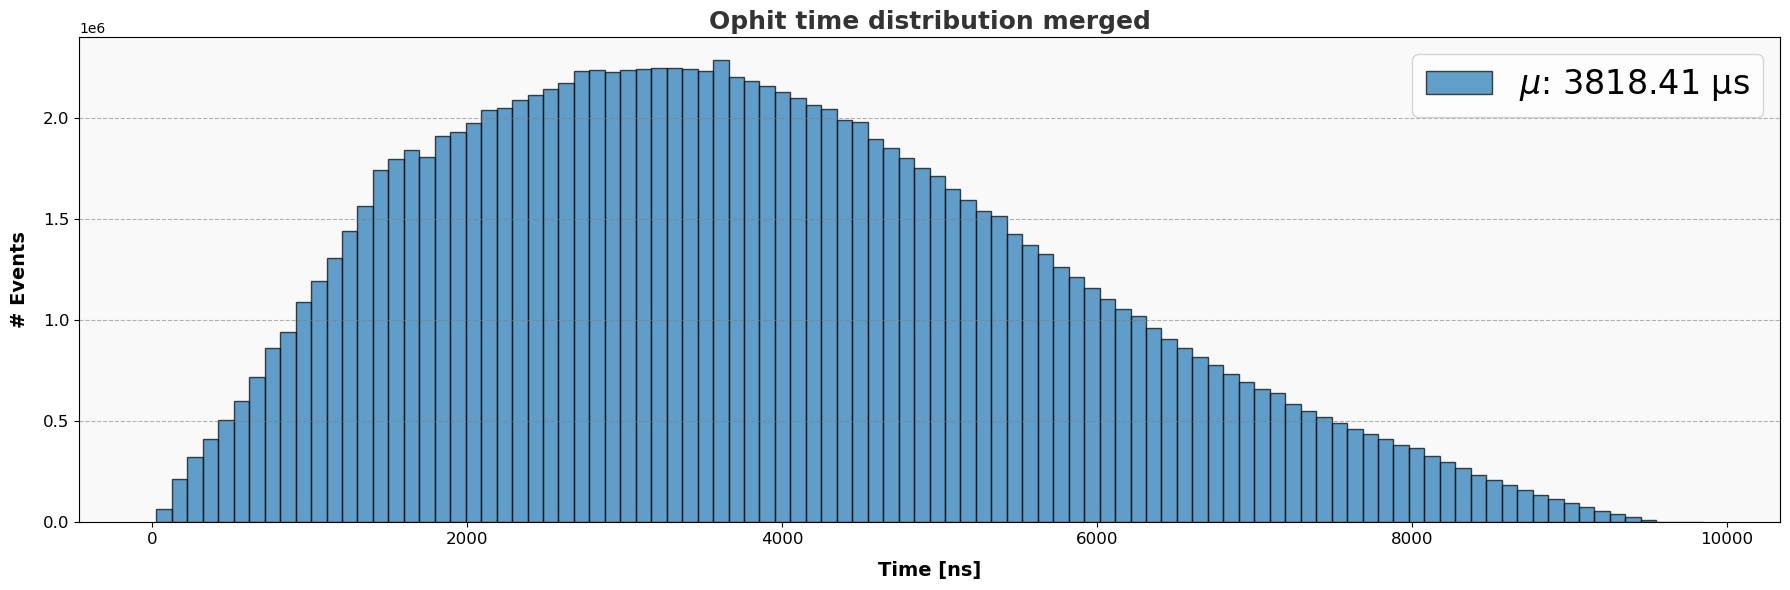

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays
# Calculate the difference and flatten it
difference = ak.to_numpy(ak.flatten(hit_t, axis=None))*1000 - ToF_outside 

# Calculate the standard deviation
std_dev = np.mean(difference)

# Set up the plot
plt.figure(figsize=(18, 6))
plt.hist(difference, bins=100, color='#1f77b4', edgecolor='black', alpha=0.7, label=f'$\mu$: {std_dev:.2f} μs')

# Customize the title and labels
plt.title('Ophit time distribution merged', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
#plt.xlim(0, 20)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  # Forces scientific notation on the y-axis

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()


The BNB is created by extracting protons from the Booster accelerator at Fermilab and impacting them on a beryllium target. The time structure of the delivered proton beam consists of a series of 81 bunches, each about 1.3 ns wide and 19 ns apart, defining a spill length of 1.6 µs

In [8]:
hit_nuvT_c= np.mod(hit_nuvT - ToF_inside, bunch_separation)
hit_t_c = hit_t
#ToF outside solo añade un shift global. ToF inside no se le mete a hit_t porque debe intentar predecirlo. Hit_t no sé si tiene sentido hacer el módulo 19 pero creo que no.

In [7]:
print(ak.min(hit_t))

0.39199999999994184


In [9]:
# Filter subarrays: keep only those with one neutrino interaction in hit_nuvT
hit_nuvX_f, hit_nuvT_fc, hit_PE_f, hit_ch_f, hit_t_fc, flash_time_f, dEpromx_f, dEpromy_f, dEpromz_f = zip(*[
    (subarray_nuvX, subarray_nuvT, subarray_PE, subarray_ch, subarray_t, subarray_flash_time, subarray_dEpromx, subarray_dEpromy, subarray_dEpromz)
    for subarray_nuvX, subarray_nuvT, subarray_PE, subarray_ch, subarray_t, subarray_flash_time, subarray_dEpromx, subarray_dEpromy, subarray_dEpromz
    in zip(hit_nuvX, hit_nuvT_c, hit_PE, hit_ch, hit_t_c, flash_time, dEpromx, dEpromy, dEpromz)
    if len(subarray_nuvT) == 1 
])

In [10]:
# Convert awkward arrays to Arrow tables
ophit_variables = pa.Table.from_pydict({
    'hit_nuvX_f': ak.to_list(hit_nuvX_f),
    'hit_nuvT_fc': ak.to_list(hit_nuvT_fc),
    'hit_PE_f': ak.to_list(hit_PE_f),
    'hit_ch_f': ak.to_list(hit_ch_f),
    'hit_t_fc': ak.to_list(hit_t_fc),
    'flash_time_f': ak.to_list(flash_time_f),
    'dEpromx_f': ak.to_list(dEpromx_f),
    'dEpromy_f': ak.to_list(dEpromy_f),
    'dEpromz_f': ak.to_list(dEpromz_f)
})

# Save to Parquet file
pq.write_table(ophit_variables, 'saved_archives/ophit_variables.parquet')

# To load some variables from the parquet file, use the following code
# table = pq.read_table('saved_archives/ophit_variables.parquet')
# hit_nuvT_f = ak.from_iter(table.column('hit_nuvT_f').to_pylist())

## 2. PE and time matrix

**With the complete data it takes ~ 7min**

In [117]:
pe_matrix, time_matrix = process_photoelectrons(hit_PE_f, hit_ch_f, hit_t_fc)

# Save the matrices to a CSV file
np.savetxt("saved_archives/pe_matrix_&_time_matrix/pe_matrix.csv", pe_matrix, delimiter=",")
np.savetxt("saved_archives/pe_matrix_&_time_matrix/time_matrix.csv", time_matrix, delimiter=",")

**Comprobación de los eventos 4 flashes**

In [143]:
file_path = '/data/vidales/opana_tree_combined_v2609.root'
file = uproot.open(file_path)
PDSMap = file['opanatree']['PDSMapTree']
ID = PDSMap['OpDetID'].array()
Type = PDSMap['OpDetType'].array()
data_dict = {id_val: (int(type_val)) for id_val, type_val in zip(ID[0], Type[0])}

In [144]:
print(nopflash_f)
indices_of_four= [index for index, value in enumerate(nopflash_f) if value == 4]
indices_of_three= [index for index, value in enumerate(nopflash_f) if value == 3]
indices_of_two= [index for index, value in enumerate(nopflash_f) if value == 2]

(2, 2, 2, 3, 2, 2, 4, 4, 4, 4, 3, 3, 2, 2, 2, 2, 3, 3, 4, 3, 2, 2, 2, 4, 3, 4, 3, 4, 2, 3, 4, 3, 2, 4, 0, 2, 2, 2, 2, 2, 2, 4, 4, 3, 4, 2, 2, 2, 2, 4, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 4, 3, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 1, 2, 2, 3, 2, 4, 3, 4, 4, 4, 2, 2, 0, 2, 2, 0, 2, 3, 2, 2, 4, 3, 2, 3, 4, 2, 4, 0, 2, 2, 2, 4, 3, 3, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 4, 2, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 3, 2, 4, 2, 3, 4, 2, 4, 4, 4, 4, 3, 2, 2, 2, 4, 2, 3, 2, 3, 4, 4, 3, 2, 2, 4, 4, 2, 2, 2, 3, 2, 4, 4, 3, 2, 2, 3, 3, 2, 2, 2, 4, 3, 3, 2, 4, 3, 2, 2, 2, 2, 4, 2, 2, 3, 2, 3, 4, 1, 2, 3, 3, 2, 2, 2, 2, 1, 4, 2, 3, 4, 2, 2, 2, 2, 4, 2, 4, 4, 3, 3, 2, 2, 2, 3, 3, 4, 2, 2, 3, 2, 3, 3, 4, 3, 3, 4, 2, 2, 2, 3, 4, 3, 2, 2, 2, 2, 3, 4, 2, 4, 2, 4, 3, 4, 4, 3, 4, 2, 2, 2, 4, 4, 3, 2, 2, 2, 3, 2, 3, 4, 3, 2, 2, 4, 2, 4, 3, 2, 2, 2, 1, 2, 4, 2, 2, 2, 2, 2, 0, 4, 2, 2, 3, 3, 2, 4, 4, 3, 3, 3, 4, 3, 1, 2, 2, 2, 2, 2, 4, 0, 4, 2, 4, 3, 2, 0, 2, 2, 3, 2, 4, 2, 2, 3, 2, 3, 2, 2, 3, 2, 4, 2, 3, 

In [145]:
hit_ch_f_four = [hit_ch_f[i] for i in indices_of_four]
hit_ch_f_three = [hit_ch_f[i] for i in indices_of_three]
hit_ch_f_two = [hit_ch_f[i] for i in indices_of_two]

In [11]:
first_flash_2 = []
second_flash_2 = []

first_flash_3 = []
second_flash_3 = []
third_flash_3 = []

first_flash_4 = []
second_flash_4 = []
third_flash_4 = []
fourth_flash_4 = []

for i in range(len(hit_ch_f_four)):
    first_flash_4.append(hit_ch_f_four[i][0])
    second_flash_4.append(hit_ch_f_four[i][1])
    third_flash_4.append(hit_ch_f_four[i][2])
    fourth_flash_4.append(hit_ch_f_four[i][3])

for i in range(len(hit_ch_f_three)):
    first_flash_3.append(hit_ch_f_three[i][0])
    second_flash_3.append(hit_ch_f_three[i][1])
    third_flash_3.append(hit_ch_f_three[i][2])

for i in range(len(hit_ch_f_two)):
    first_flash_2.append(hit_ch_f_two[i][0])
    second_flash_2.append(hit_ch_f_two[i][1])



In [105]:
def even_odd(hit_ch_f):
    separated_arrays = []
    for array in hit_ch_f:
        # Split into even and odd subarrays
        evens = array % 2 == 0
        odds = ~evens
        
        # Filter the values based on the conditions
        even_subarrays = array[evens]
        odd_subarrays = array[odds]
        
        separated_arrays.append({"even": even_subarrays, "odd": odd_subarrays})

    # Output separated arrays for inspection
    return separated_arrays

In [106]:
separate_four = even_odd(hit_ch_f_four)
separate_three = even_odd(hit_ch_f_three)
separate_two = even_odd(hit_ch_f_two)

In [110]:
def total_even_odd(array):
    # Count non-zero subarrays for even
    total_even_subarrays = sum(1 for entry in array for subarray in entry['even'] if len(subarray) > 0)
    
    # Count non-zero subarrays for odd
    total_odd_subarrays = sum(1 for entry in array for subarray in entry['odd'] if len(subarray) > 0)
    
    return total_even_subarrays, total_odd_subarrays

In [111]:
even_four, odd_four = total_even_odd(separate_four)
even_three, odd_three = total_even_odd(separate_three)
even_two, odd_two = total_even_odd(separate_two)

In [119]:
print("Four flashes")
print("Total Even Subarrays:", even_four)
print("Total Odd Subarrays:", odd_four)
print("Total:", even_four + odd_four)
print("Total length:", len(hit_ch_f_four)*4)

print("Three flashes")
print("Total Even Subarrays:", even_three)
print("Total Odd Subarrays:", odd_three)
print("Total:", even_three + odd_three)
print("Total length:", len(hit_ch_f_three)*3)

print("Two flashes")
print("Total Even Subarrays:", even_two)
print("Total Odd Subarrays:", odd_two)
print("Total:", even_two + odd_two)
print("Total length:", len(hit_ch_f_two)*2)

Four flashes
Total Even Subarrays: 7920
Total Odd Subarrays: 7920
Total: 15840
Total length: 15840
Three flashes
Total Even Subarrays: 5070
Total Odd Subarrays: 4803
Total: 9873
Total length: 9873
Two flashes
Total Even Subarrays: 7569
Total Odd Subarrays: 6065
Total: 13634
Total length: 13634


In [82]:
# Convert to a list for printing
even_list = ak.to_list(separated_arrays[200]['odd'])

# Print the entire list
for subarray in even_list:
    print(subarray)

[91, 273, 247, 173, 63, 41, 163, 115, 69, 301, 295, 163, 85, 95, 173, 301, 115, 225, 171, 147, 249, 217, 163, 139, 303, 139, 95, 173, 163, 15, 225, 251, 193, 147, 249, 301, 247, 295, 217, 89, 7, 91, 227, 171, 163, 247, 295, 149, 301, 171, 93, 89, 249, 241, 87, 225, 7, 163, 147, 91, 301, 11, 225, 247, 147, 13, 303, 149, 145, 303, 87, 163, 67, 251, 163, 147, 251, 227, 171, 163, 91, 69, 275, 93, 87, 301, 225, 139, 39, 11, 163, 93, 95, 13, 87, 227, 89, 247, 163, 145, 301, 249, 39, 171, 85, 13, 303, 247, 145, 93, 295, 225, 173, 39, 171, 147, 13, 249, 193, 301, 139, 171, 91, 251, 217, 145, 71, 11, 303, 163, 85, 301, 139, 63, 249, 227, 225, 163, 119, 89, 87, 71, 273, 251, 173, 41, 139, 145, 9, 303, 247, 15, 225, 139, 249, 147, 295, 171, 119, 93, 9, 275, 87, 303, 249, 241, 227, 171, 163, 93, 85, 71, 39, 247, 173, 67, 63, 225, 193, 61, 217, 163, 139, 115, 249, 67, 85, 173, 171, 147, 93, 303, 247, 217, 145, 89, 85, 67, 37, 13, 139, 115, 273, 241, 163, 69, 93, 275, 147, 91, 61, 249, 241, 225, 197

In [51]:
a= ak.concatenate(fourth_flash_4)
mapped = [data_dict[i] for i in a]

In [50]:
from collections import Counter

# Count occurrences of 0, 1, 2, and 3 in mapped
count_dict = Counter(mapped)

# Ensure counts for 0, 1, 2, and 3 are in the dictionary, defaulting to 0 if absent
counts = {num: count_dict.get(num, 0) for num in range(4)}

print(counts)

{0: 0, 1: 0, 2: 447814, 3: 521149}


In [40]:
combined_array = (ak.concatenate(first_flash_4), ak.concatenate(second_flash_4), ak.concatenate(third_flash_4), ak.concatenate(fourth_flash_4))

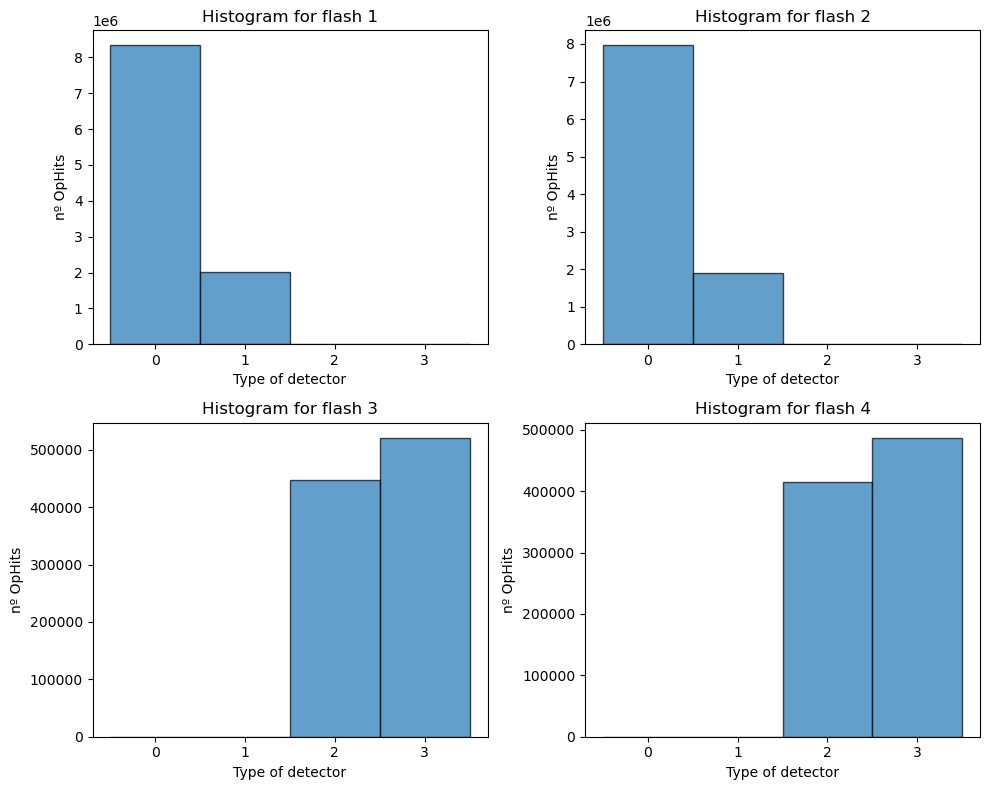

In [41]:
# Create a figure for subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten the axes for easier indexing

# Iterate through each subarray and plot the histogram
for idx, subarray in enumerate(combined_array):
    # Map the values in the subarray using the dictionary
    mapped_values = [data_dict[x] for x in subarray if x in data_dict]
    
    # Create histogram
    axes[idx].hist(mapped_values, bins=[0, 1, 2, 3, 4], alpha=0.7, edgecolor='black', align='left')
    axes[idx].set_title(f'Histogram for flash {idx + 1}')
    axes[idx].set_xlabel('Type of detector')
    axes[idx].set_ylabel('nº OpHits')
    axes[idx].set_xticks([0, 1, 2, 3])  # Set x-ticks to match the bins

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

With this code I see if there's flashes with simultaneously trigger XAs and PMTs

In [128]:
def transform_arrays(flash_arrays, id_mapping):
    transformed_arrays = []  # List to hold the transformed arrays

    # Iterate through each awkward array
    for flash_array in flash_arrays:
        # Create a new array to hold the transformed data
        transformed_flash_array = ak.Array([
            [id_mapping[id_] for id_ in flash if id_ in id_mapping] 
            for flash in flash_array
        ])
        transformed_arrays.append(transformed_flash_array)

    return transformed_arrays


In [166]:
two_0123 = transform_arrays(hit_ch_f_two, data_dict)
three_0123 = transform_arrays(hit_ch_f_three, data_dict)
four_0123 = transform_arrays(hit_ch_f_four, data_dict)

In [168]:

def count_flash_possibilities(flash_matrices):
    counts = {
        'valid_01': 0,  # Count for flashes containing (0, 1)
        'valid_23': 0,  # Count for flashes containing (2, 3)
        'conflict': 0,  # Count for flashes containing (0, 1, 2, 3)
        'valid_other': 0 # Count for flashes with other values
    }

    for flash_matrix in flash_matrices:
        for flash in flash_matrix:
            unique_values = set(flash)
            contains_01 = all(value in unique_values for value in (0, 1))
            contains_23 = all(value in unique_values for value in (2, 3))
            contains_all = all(value in unique_values for value in (0, 1, 2, 3))

            if contains_all:
                counts['conflict'] += 1
            elif contains_01:
                counts['valid_01'] += 1
            elif contains_23:
                counts['valid_23'] += 1
            else:
                counts['valid_other'] += 1

    return counts

In [169]:
print('Four flashes')
count_flash_possibilities(four_0123)
print('Three flashes')
count_flash_possibilities(three_0123)
print('Two flashes')
count_flash_possibilities(two_0123)

Four flashes
Three flashes
Two flashes


{'valid_01': 6841, 'valid_23': 6790, 'conflict': 0, 'valid_other': 3}